# Natural Language Processing: An Application in Public Policy

# By Junaid Shah

The purpose of this notebook is to guide readers through the process of analyzing the FOMC statements, estimating topic models (i.e. extracting topics), tools for model selection, and calculating measures of negativity and uncertainty within the topic models. This notebook outputs the topic weights and probabilities and proportions of negativite and uncertain language within the statements into a csv file. Those weights and proportions are then used in a regression analysis.

## Part 1: Text Preprocessing

In [ ]:
# TRY RUNNING CELL BELOW! If it does not work, create a virtual environment (and respective kernel),
# uncomment the code below and run to install dependencies
#!pip install -r requirements.txt

In [3]:
# Install missing packages if they are not already installed
!pip install PyPDF2
!pip install wordcloud
!pip install gensim
!pip install nltk
!pip install pandas-datareader

# Standard libraries for data frames, arrays, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import seaborn as sns
sns.set(style="white")
%matplotlib inline

# Import Scikit Learn for preprocessing tools and algorithms
import sklearn

# Import library for setting dates
import datetime as dt

# Import library for reading pdf files
import PyPDF2

# Import wordclouds for visualizing topics
import wordcloud

# Import gensim library for calculating coherence measures
import gensim

# Import natural language package to remove stopwords and lemmatize terms
import nltk

# Import digits module to filter out numbers
#import re
import string

# Import statsmodels for statistical analysis
import statsmodels

# Import pandas_datareader to get financial data from Yahoo
import pandas_datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 54.9 MB/s eta 0:00:00


In [5]:
# Import in unprocessed statements scraped from Scrapy into a csv file
data = pd.read_csv('/content/statements.csv', skipinitialspace=True)
data.head(10)

,Date,Statement
0,10/05/1999,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
1,18/05/1999,\r\r\r\r\r\r\r\r\r\r\t\tWhile the FOMC did not...
2,30/06/1999,\r\r\r\r\r\r\r\r\tLabor markets have continued...
3,24/08/1999,\r\r\r\r\r\r\r\r\t With financial markets fun...
4,16/11/1999,\r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
5,21/12/1999,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
6,02/02/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
7,10/03/2000,\r\r\r\r\r\r\r\r\r\rThe Federal Open Market Co...
8,21/03/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
9,16/05/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...


In [6]:
statements = data['Statement']
statements.head(10)

,Statement
0,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
1,\r\r\r\r\r\r\r\r\r\r\t\tWhile the FOMC did not...
2,\r\r\r\r\r\r\r\r\tLabor markets have continued...
3,\r\r\r\r\r\r\r\r\t With financial markets fun...
4,\r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
5,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
6,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
7,\r\r\r\r\r\r\r\r\r\rThe Federal Open Market Co...
8,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
9,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...


### The text preprocessing steps
Text preprocessing is an important part of the NLP pipeline as it allows us to get more information out of our documents and discard any irrelevant information. The steps you take for preprocessing are dependent on the application, however there are some common steps that are normally taken in many NLP applications.

The preprocessing steps I take here are:
- Lowercasing
- Remove extra spacing
- Remove punctuation
- Removing digits
- Remove stopwords
- Lemmatization

An example of the process for an FOMC statement:

<img src="images/preprocessing.png" alt="FOMC Statement, May 10, 1999" title="Text Preprocessing Example" />

In [7]:
# Import tools to tokenize, remove stopwords, and lemmatize (or stem) words
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords') # download collection of stopwords from NLTK
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
nltk.download('wordnet') # download wordnet dictionary of lemmas
from nltk.stem import WordNetLemmatizer
from string import digits

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
# Lowercase, remove digits, and lemmatize statements
n=len(statements)
raw_doc_length = list(range(0, n))
doc_length = list(range(0, n))
#porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for i in range(n):
    # Lowercase the statement
    lowercase = statements[i].lower()
    # Tokenize the statement
    tokenize = CountVectorizer().build_tokenizer()(lowercase)
    # Count raw number of words
    raw_doc_length[i] = len(tokenize)
    # Remove digits
    remove_digits = [w for w in tokenize if not w.isdigit()]
    # Remove stopwords
    no_stopwords = [w for w in remove_digits if not w in stopwords.words('english')]
    # Lemmatize
    lemma = [lemmatizer.lemmatize(w) for w in no_stopwords]
    # Count preprocessed words
    doc_length[i] = len(lemma)
    # Join each statement back together
    statements[i] = ' '.join(lemma)

In [9]:
# Example of processed statement
statements[0]

'federal open market committee decided today leave target federal fund rate unchanged strengthening productivity growth fostering favorable trend unit cost price much recent information suggests trend sustained nonetheless growth demand continued outpace supply evidenced decreasing pool available worker willing take job circumstance federal open market committee need especially alert month ahead potential cost increase significantly excess productivity manner could contribute inflation pressure undermine impressive performance economy background committee adopted directive biased toward possible firming policy going forward committee member emphasized directive signify commitment near term action committee need evaluate additional information balance aggregate supply demand condition financial market'

In [10]:
# Save dates in a list
dates=data['Date']
x = [dt.datetime.strptime(d,'%d/%m/%Y').date() for d in dates]

In [11]:
# Transform raw document length list into a numpy array
raw_doc_length = np.asarray(raw_doc_length)

In [12]:
# Transform preprocessed document length list into a numpy array
doc_length = np.asarray(doc_length)

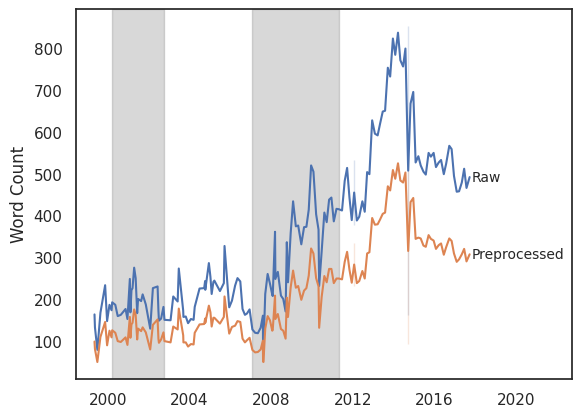

In [14]:
# Create plot of document length
import os
if not os.path.exists('images'):
    os.makedirs('images')
data = pd.DataFrame({'Year': x, 'Raw':raw_doc_length, 'Preprocessed':doc_length})
ax1=sns.lineplot(x='Year', y='Raw', data=data)
ax2=sns.lineplot(x='Year', y='Preprocessed', data=data)
ax1.set(xlabel ='', ylabel='Word Count')
ax2.set(xlabel ='', ylabel='Word Count')
ax1.text(x=date2num(data["Year"].iloc[-1])+30, y=data['Raw'].iloc[-1], s="Raw",
         horizontalalignment='left', size='small', verticalalignment='center')
ax2.text(x=date2num(data["Year"].iloc[-1])+30, y=data['Preprocessed'].iloc[-1], s="Preprocessed",
         horizontalalignment='left', size='small', verticalalignment='center')
# Shade in early 2000s crisis
ax2.axvspan(x[7], x[32], alpha=0.30, color='gray')
# Shade in global financial crisis
ax2.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.xlim(xmax=date2num(data["Year"].iloc[-1])+1826)
plt.savefig('images/document_length.png', dpi=300)
plt.show()

## Part 2: Feature Extraction

Next, we must extract features from the normalized text using the Sci-kit Learn package. We will extract them by transforming the pure text into a weighted document-term matrix. We create unigram and bigram representations. This allows us to look at the frequency of single words and contiguous pairs of words (unigram and bigram, respectively).

Our final weighted matrix is derived from the __Bag of Words Model (BOW)__. BOW is simply a matrix that collects the count of each unique term in the corpus in each document. It has the dimensions (number of documents x number of unique terms).

For a quick example, consider that we have three sentences, each representing a document:
1. I love dogs
2. I hate dogs and knitting
3. knitting is my hobby and my passion

An example of the Bag of Words model would be

<img src="images/bow.jpg" alt="Bag of Words Model" title="BoW model example" />

The Bag of Words model is a useful representation, but it can be improved upon. To make this representation more informative, we apply the term frequency-inverse document frequency weighting scheme to each element of the matrix. The idea behind this is to give the highest priority to words that occur frequently but in a low number of documents.

Term-frequency-inverse document frequency is represented by the following equation

$$ tf-idf = tf(t,d) \text{ x } idf(t, D) $$

where $$idf(t, D) = log(\dfrac{D}{df_{t}})$$

with $tf(t,d)$ and $idf(t,D)$ representing the rewarding term frequency and penalizing document frequency terms, respectively, where $t$ refers to the term and $D$ is the total number of documents.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# Create unigram TF-IDF weighted matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=0.05, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(statements).toarray()
X_tfidf.shape

(159, 552)

Although we do not include them in this analysis, you could extend this analysis to include bigrams (word pairs). This can account for words commonly used together such as 'monetary policy', 'financial crisis', 'discount rate', etc.

In [18]:
# Create bigram TF-IDF weighted matrix
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.95)
X1_tfidf = bigram_tfidf_vectorizer.fit_transform(statements).toarray()
X1_tfidf.shape

(159, 1486)

## Part 3: Topic Modeling with Non-negative Matrix Factorization

<img src="images/NMF.jpg" alt="Visualization of NMF algorithm" title="Non-negative Matrix Factorization" />

- Developed by Lee and Seung (1999)
- Algorithm learns __parts-based representations__
- __W__ matrix tracks weights of topics in documents
- __H__ matrix tracks weights of unique terms in topics

Minimizes the following objective function:
$$ \dfrac{1}{2}||A - WH||_{F}^{2} = \dfrac{1}{2}\sum_{i=1}^{M}\sum_{j=1}^{N}(A_{ij}-(WH)_{ij})^{2} $$

In [19]:
# Import NMF from Scikit Learn and
from sklearn.decomposition import NMF
from sklearn import metrics

In [20]:
# Create a function that prints the top words of a topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [21]:
# Create a function that prints the topics as a list
def print_topics(model, feature_names, n_top_words, n_components):
    topics=list(range(n_components))
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx]=[str(feature_names[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

In [24]:
# Get the terms from the TF-IDF matrix
tfidf_feature_names_n1 = tfidf_vectorizer.get_feature_names_out()

In [25]:
# Estimate preliminary unigram NMF model with three topics
nmf = NMF(n_components=3, random_state=1,
          beta_loss='kullback-leibler', solver='mu',
          max_iter=10000).fit(X_tfidf) # minimizes using kullback-leibler with unigrams
print_top_words(nmf, tfidf_feature_names_n1, 15)

Topic #0: inflation labor longer security agency employment term policy range condition percent maximum appropriate run consistent
Topic #1: board growth approved basis action point inflation discount reserve price risk sustainable productivity belief policy
Topic #2: security inflation financial credit level recovery reserve promote continue condition price purchase housing consistent low



## Part 4: Parameter Selection for Non-negative Matrix Factorization

One of the main issues in topic modelling is deciding on the k parameter. This parameter is the number of topics to estimate in the model. Naturally, when we develop a topic model in the social sciences, we would like our topics to be defined and interpretable. Therefore, to automatically select the k parameter, we use __measures of topic coherence__. In general, topic coherence measures the semantic similarity between the top terms used to represent a topic. There exists numerous measures of coherency with the __most common measures being the $C_{UMass}$, $C_{UCI}$, and $C_{V}$__.

There exists a __distinction between extrinsic and intrinsic topic coherency measures__. Extrinsic measures use __external datasets__ to assess coherency or what we refer to as "background corpora." The argument behind these measures is that using the same dataset to assess coherency would reinforce noise or unusual word statistics. Standard measures for this is the $C_{UCI}$ and the $C_{V}$. Intrinsic measures simply use the main corpus and use empirical estimates of probabilities to define its measure. A standard intrinsic coherence measure is the $C_{UMass}$. All of these measures are openly available in the gensim package.

Since there are no suitable background sources of communication for the FOMC statements, we use $C_{UMass}$ coherency developed by Mimno et al. (2011). Specifically, it measures the ability of a higher weighted word in prediciting a lower weighted word. The equation follows

$$ C_{UMass}(w_i, w_j)^{(t)} = \dfrac{2}{N(N-1)}\sum_{i=2}^{N}\sum_{j=1}^{i-1}log\dfrac{P(w_{i}^{(t)},w_{j}^{(t)}) + \epsilon}{P(w_{j}^{(t)})} $$

In [26]:
# Retrieve modules to set corpous and get coherence. Show logging details to see progress.
from gensim import corpora, models

In [27]:
# Tokenize each statement, add terms to dictionary, and build main corpus
for i in range(n):
    statements[i] = CountVectorizer().build_tokenizer()(statements[i])
dictionary=corpora.Dictionary(statements)
corpus=[dictionary.doc2bow(doc) for doc in statements]

In [28]:
# Parameter selection using intrinsic coherence measure, u_mass. This measure uses the main corpus, which has its issues according to XXX paper
end_k=30
coherencenmf=[]
for k in range(3,end_k+1):
    n_components=k
    nmf = NMF(n_components=n_components, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
    topics=print_topics(nmf, tfidf_feature_names_n1, 15, n_components)
    cm_NMF = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencenmf.append(cm_NMF.get_coherence())
    print('k= %d' % k)
    print_top_words(nmf, tfidf_feature_names_n1, 15)

k= 3
Topic #0: inflation labor longer security agency employment term policy range condition percent maximum appropriate run consistent
Topic #1: board growth approved basis action point inflation discount reserve price risk sustainable productivity belief policy
Topic #2: security inflation financial credit level recovery reserve promote continue condition price purchase housing consistent low

k= 4
Topic #0: inflation labor longer security agency employment term range appropriate condition maximum percent policy run consistent
Topic #1: board basis approved inflation growth point action discount reserve bank price potential percent risk request
Topic #2: security inflation level recovery credit financial purchase reserve mandate consistent low subdued continue condition price
Topic #3: belief jr underlying monetary robust coupled equal policy providing stance perceives growth ferguson susan bies

k= 5
Topic #0: inflation labor longer security agency employment term range maximum appr

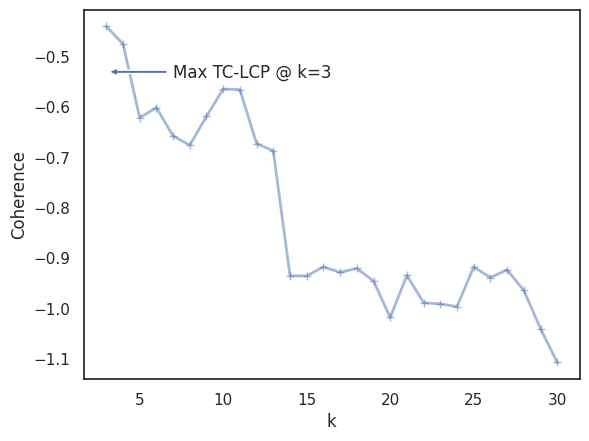

In [29]:
# Plot the coherence over the different 'k' selections
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencenmf, 'b+-', linewidth=2, label='UMass Coherency', alpha=0.5, markevery=1)
ax.set_xlabel('k')
ax.set_ylabel('Coherence')
ax.annotate('Max TC-LCP @ k=3',
             xy=(3, -0.53001054467878117),
             xycoords='data',
             xytext=(7, -0.54),
             arrowprops=dict(arrowstyle="simple"))
plt.savefig('images/UMassNMF.png', dpi=300)
plt.show()

Based on the three extrinsic coherency measures using the FOMC minutes as a background corpus, there is a consensus to estimate the model with k=3 as this gives the highest level of coherency. Therefore, we perform NMF with three components below and look to give an interpretation of these topics.

In [30]:
best_nmf = NMF(n_components=3, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
print_top_words(best_nmf, tfidf_feature_names_n1, 15)
best_topics=print_topics(best_nmf, tfidf_feature_names_n1, 15, 3)

Topic #0: inflation labor longer security agency employment term policy range condition percent maximum appropriate run consistent
Topic #1: board growth approved basis action point inflation discount reserve price risk sustainable productivity belief policy
Topic #2: security inflation financial credit level recovery reserve promote continue condition price purchase housing consistent low



I believe that the topic model performed well in the analysis of the FOMC statements as each topic is clearly interpretable. The first topic represents "policy objectives" as it includes descriptors like inflation, security, employment, and price. These are words related to the Federal Reserve's explicit mandates. The second topic is related to "monetary policy tools and targets." Finally, the third topic is related to "financial markets." These are three topics that are useful for further analysis.

In [31]:
# Extract the weights for the model for later regression analysis.
W = best_nmf.fit_transform(X_tfidf) # topic-document weights
H = best_nmf.components_ # word-topic weights

In [32]:
# Dimensions of the W matrix
W.shape

(159, 3)

In [33]:
H.shape

(3, 552)

## Part 5: Visualization of the NMF Topics

In this section, we plot the topic-document weights as a function of the document dates. This analysis serves the purpose of providing a time series of topic weights to see the intensity of topics over time. This analysis is useful to map historical events back to the output of the topic model as this will provide even more validity to the performance of these models.

In [34]:
# Create dates and NMF weight variables
nmf_theme1_weights = W[:,0]
nmf_theme2_weights = W[:,1]
nmf_theme3_weights = W[:,2]

In [35]:
# A function to plot the weights of the themes
def plot_theme_weights(weights, name, color):
    fig, ax = plt.subplots()
    ax.plot(x, weights, '{}-'.format(color), linewidth=2, label='topic 1', alpha=0.6)
    ax.set_ylabel('Weight')
    ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
    ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
    plt.savefig('images/{}.png'.format(name), dpi=300)
    plt.show()

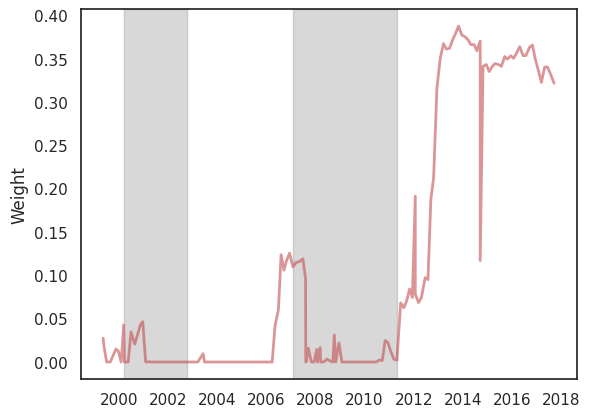

In [36]:
# Plot topic 1 weights as a time series
plot_theme_weights(weights=nmf_theme1_weights, name='NMFWeights1', color='r')

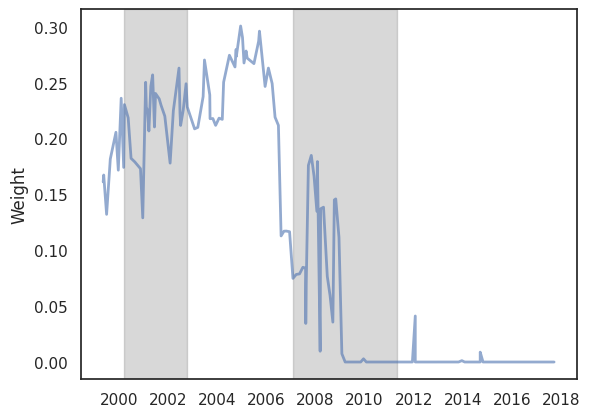

In [37]:
# Plot topic 2 weights as a time series
plot_theme_weights(weights=nmf_theme2_weights, name='NMFWeights2', color='b')

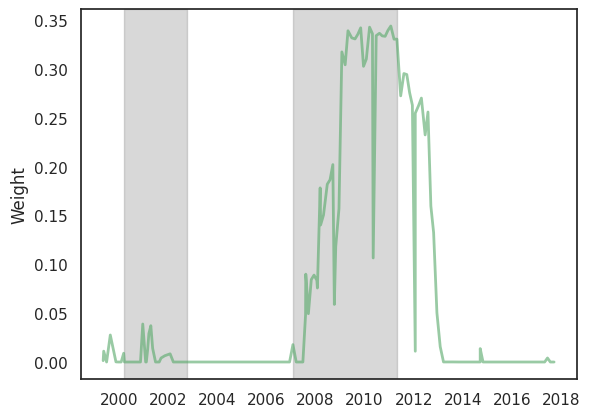

In [38]:
# Plot topic 3 weights as a time series
plot_theme_weights(weights=nmf_theme3_weights, name='NMFWeights3', color='g')

In [40]:
# Save the weights to a csv file
import os
if not os.path.exists('results'):
    os.makedirs('results')
W = pd.DataFrame(W)
W.to_csv("results/weights.csv")

In this section, I create word clouds for the topics using the wordcloud package. This is good for representing topics in a coherent and clear way. It is also possible to use wordle.net, which is an online, interactive wordcloud creator. It provides more visually appealing wordclouds than the wordcloud package but is not capable of being integrated into Python. It is highly suggested to use that for creating wordclouds to be included in publications.

In [41]:
from wordcloud import WordCloud

In [42]:
def create_wordcloud(words, name):
    topic = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(words))
    plt.figure(figsize=(10, 6))
    plt.imshow(topic, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('images/{}.png'.format(name), dpi=300) # Save figure
    plt.show()

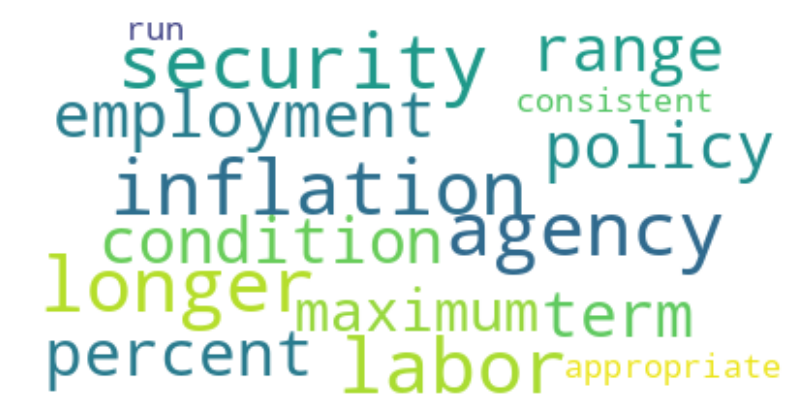

In [43]:
create_wordcloud(words=best_topics[0], name='NMF Theme 1')

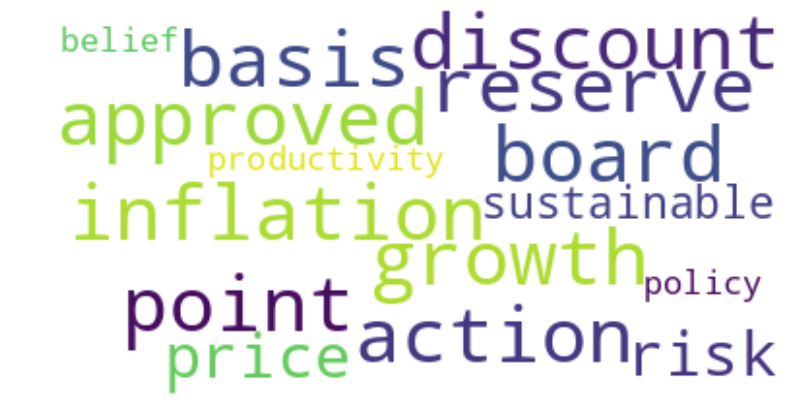

In [44]:
create_wordcloud(words=best_topics[1], name='NMF Theme 2')

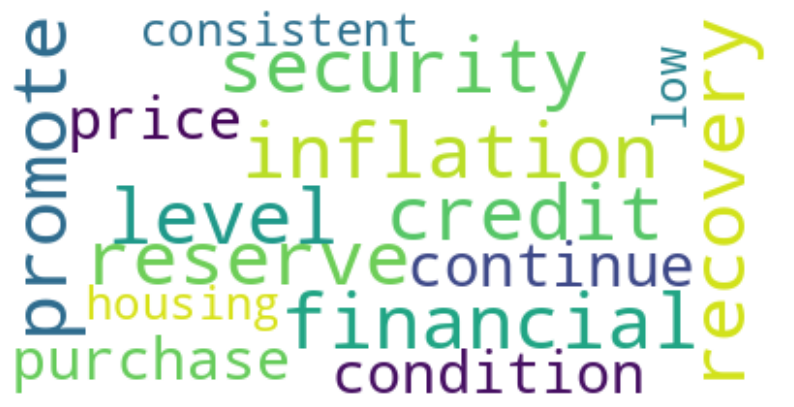

In [45]:
create_wordcloud(words=best_topics[2], name='NMF Theme 3')

## Part 6: Topic Modeling using Latent Dirichelet Allocation

<img src="images/LDA.jpg" alt="Visualization of LDA algorithm" title="Latent Dirichlet Allocation" />

Latent Dirichlet Allocation (LDA) is a probabilistic topic model. What this means is that LDA depends on probabilities to estimate the the parameters of interest. In this model we estimate two key parameters of interest: $\theta_d$ and $\beta_k$.

$\theta_d$ is the analog of the $W$ matrix in NMF and looks at the topic share in the document $d$, while $\beta_k$ is the analog of the $H$ matrix in NMF and estimates the weights of the terms in the topics.

Details about LDA can be found in the original paper by Blei et al. (2003).

In [46]:
# Import LDA model
from sklearn.decomposition import LatentDirichletAllocation

In [48]:
# Parameter selection using intrinsic coherence measure, u_mass. This measure uses the main corpus, which has its issues according to XXX paper
end_k=30
coherencelda=[]
for k in range(3,end_k+1):
    n_components=k
    ldamodel = LatentDirichletAllocation(doc_topic_prior = 1/n_components, topic_word_prior = 0.025, n_components=n_components, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
    topics=print_topics(ldamodel, tfidf_feature_names_n1, 15, n_components)
    cm_LDA = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencelda.append(cm_LDA.get_coherence())
    print('k= %d' % k)
    print_top_words(ldamodel, tfidf_feature_names_n1, 15)
print(coherencelda)

k= 3
Topic #0: inflation security longer labor term condition policy price agency pace consistent level fund percent employment
Topic #1: credit reserve period promote subdued financial low resource continues liquidity overall facility weak tight exceptionally
Topic #2: board growth basis action approved point discount sustainable available reserve bank risk productivity belief today

k= 4
Topic #0: inflation labor longer percent objective employment term range expected run condition policy maximum measure indicator
Topic #1: security purchase consistent mandate level inflation mortgage agency recovery backed financial anticipates low time longer
Topic #2: jr belief equal robust coupled attainment providing underlying roughly perceives roger susan ferguson bies olson
Topic #3: board growth inflation action basis approved point reserve risk bank price discount percent today available

k= 5
Topic #0: inflation security longer agency labor consistent employment purchase mortgage range man

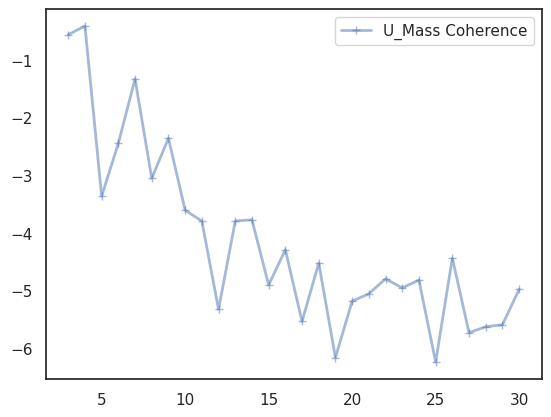

In [49]:
# Plot the coherence over the different 'k' selections
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencelda, 'b+-', linewidth=2, label='U_Mass Coherence', alpha=0.5, markevery=1)
ax.legend()
plt.show()

In [51]:
lda = LatentDirichletAllocation(doc_topic_prior = 1/3, topic_word_prior = 0.025, n_components=3, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
print_top_words(lda, tfidf_feature_names_n1, 15)
lda_topics=print_topics(lda, tfidf_feature_names_n1, 15, 3)

Topic #0: inflation security longer labor term condition policy price agency pace consistent level fund percent employment
Topic #1: credit reserve period promote subdued financial low resource continues liquidity overall facility weak tight exceptionally
Topic #2: board growth basis action approved point discount sustainable available reserve bank risk productivity belief today



## Part 7: Visualization of the LDA Topics

In [52]:
# Get probabilities from LDA model
P = lda.transform(X_tfidf) # Get a topic-document probability matrix
P

array([[0.31801728, 0.13464065, 0.54734207],
       [0.24041223, 0.17119837, 0.5883894 ],
       [0.26119111, 0.10001752, 0.63879138],
       [0.21880742, 0.1460959 , 0.63509669],
       [0.22931168, 0.17125386, 0.59943446],
       [0.29452065, 0.18368151, 0.52179784],
       [0.12632515, 0.09562919, 0.77804566],
       [0.40355294, 0.08037358, 0.51607348],
       [0.09879652, 0.08257569, 0.81862779],
       [0.14419826, 0.09203145, 0.76377029],
       [0.28088104, 0.04199904, 0.67711992],
       [0.26718124, 0.04501301, 0.68780575],
       [0.36539334, 0.09212357, 0.54248309],
       [0.42205974, 0.13039914, 0.44754112],
       [0.14926295, 0.12368099, 0.72705606],
       [0.05691545, 0.08334322, 0.85974132],
       [0.15861209, 0.12701034, 0.71437757],
       [0.2353814 , 0.10680693, 0.65781167],
       [0.18912227, 0.16040066, 0.65047707],
       [0.2287895 , 0.11128015, 0.65993035],
       [0.06282279, 0.12741004, 0.80976717],
       [0.13415361, 0.09890488, 0.76694151],
       [0.

In [53]:
# Create variables of probabilities
lda_theme1_probabilities = P[:,0]
lda_theme2_probabilities = P[:,1]
lda_theme3_probabilities = P[:,2]

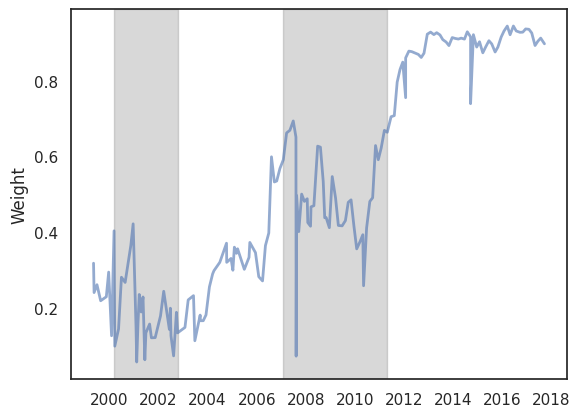

In [54]:
# Plot topic 1 probabilities as a time series
plot_theme_weights(weights=lda_theme1_probabilities, name='LDAProbabilities1', color='b')

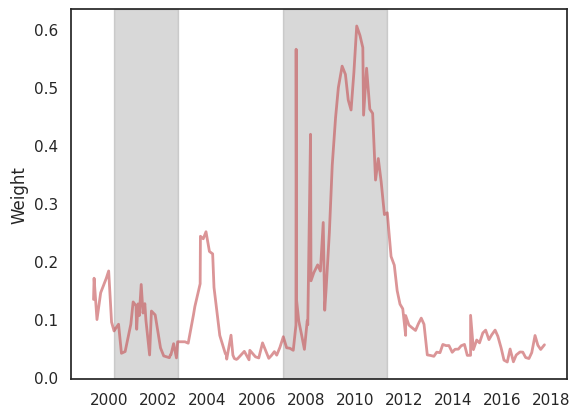

In [55]:
# Plot topic 2 probabilities as a time series
plot_theme_weights(weights=lda_theme2_probabilities, name='LDAProbabilities2', color='r')

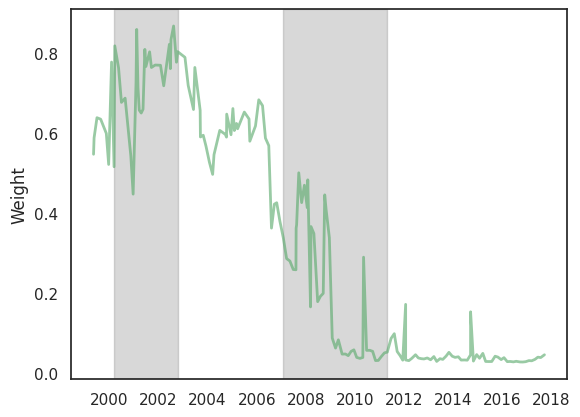

In [56]:
# Plot topic 3 probabilities as a time series
plot_theme_weights(weights=lda_theme3_probabilities, name='LDAProbabilities3', color='g')

In [57]:
# Save lda probabilities
P = pd.DataFrame(P)
P.to_csv("results/probabilities.csv")

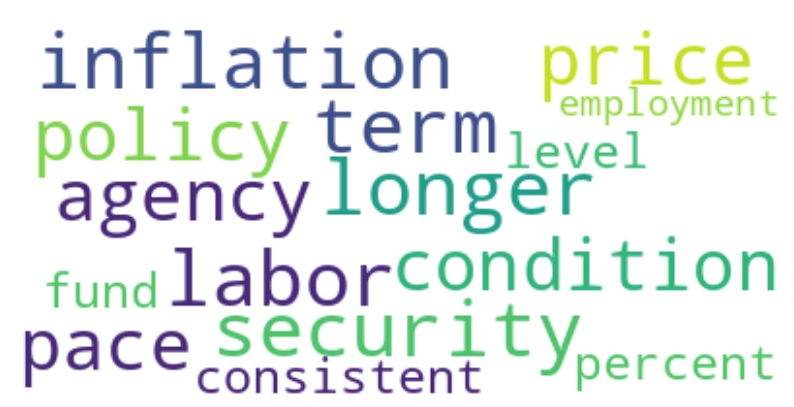

In [58]:
create_wordcloud(words=lda_topics[0], name='LDA Theme 1')

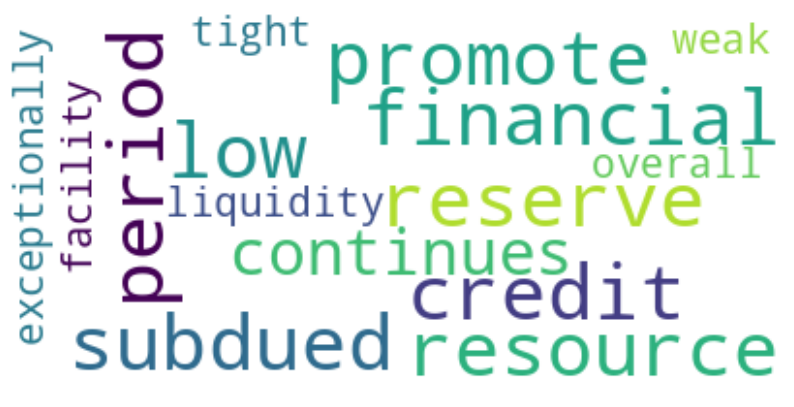

In [59]:
create_wordcloud(words=lda_topics[1], name='LDA Theme 2')

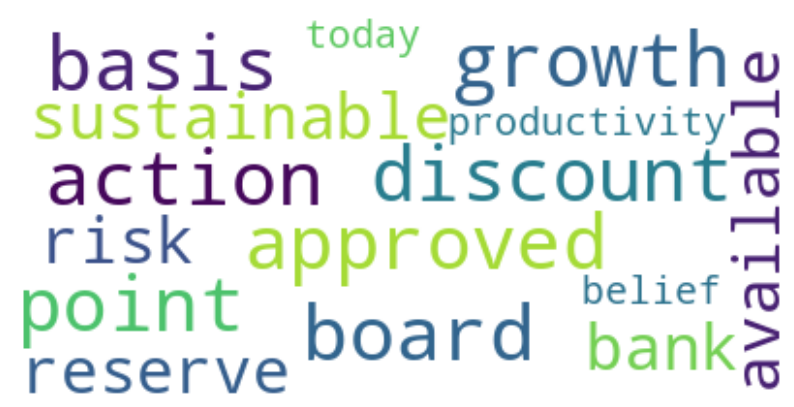

In [60]:
create_wordcloud(words=lda_topics[2], name='LDA Theme 3')

### Brief Comparison of LDA and NMF Coherency

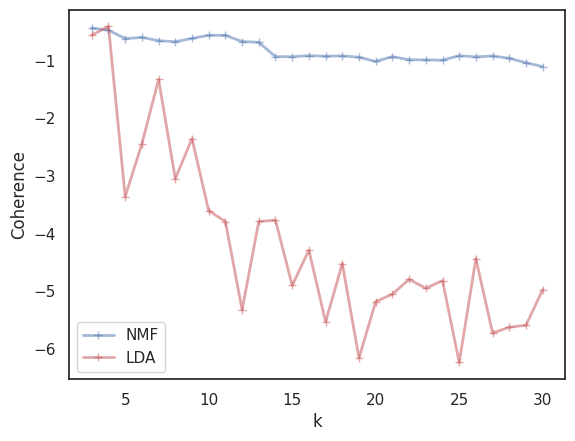

In [61]:
# Plot the UMass coherence measure for both LDA and NMF
fig, ax = plt.subplots()
ax.plot(list(range(3, 30+1)), coherencenmf, 'b+-', linewidth=2, label='NMF', alpha=0.5, markevery=1)
ax.plot(list(range(3, 30+1)), coherencelda, 'r+-', linewidth=2, label='LDA', alpha=0.5, markevery=1)
ax.legend()
ax.set_ylabel('Coherence')
ax.set_xlabel('k')
plt.savefig('images/nmf_lda_coherence.png', dpi=300)
plt.show()

We see that NMF performs better than LDA (as measured by UMass coherence) over a large range of $k$ values.

It is likely that this is specific to this corpus in general. One possible reason this is the case is that LDA is probabilisitc and needs to learn from a large dataset to perform better, while the FOMC statements do not provide this since there are not many and they are short. Therefore, factorization methods seem to perform much better at capturing local patterns in smaller datasets.

__NOTE:__ At the moment, I will neglect some of the current research deriving factorization methods as special cases of probabilistic models :)

Falls in line with examples such as:
- Least squares $\approx$ linear regression model with normally distributed errors
- K Means clustering $\approx$ a specific case of a general mixture model

## Part 8: Establishing Polarity in FOMC Statements

In this section, I will estabish the polarity/sentiment of the FOMC statements. I will use a dictionary-based method that uses the Loughran and McDonald (2011) financial dictionary. This dataset is advantageous as it is a discipline-specific dictionary which is more relevant to central banking language and also contains terminology that would be familiar to financial market participants. Additionally, this provides us a systematic benchmark for establishing polarity that does not require us to choose a list of words that are relevant, which would influence the outcome of our models. The categories are entitled 'negative', 'positive', 'uncertainty', 'litigious', 'modal', and 'constraining.'

The master dictionary and list of words by sentiment can be found at this [website](http://sraf.nd.edu/textual-analysis/resources/).

In [66]:
# Read in pdf file of the list of negative financial terms
pdfFileObj = open('/content/LM_Negative.pdf','rb')
pdfReader = PyPDF2.PdfReader(pdfFileObj)
len(pdfReader.pages)

52

In [68]:
# Collect words from each page and lowercase them
negative=[]
for pageNum in range(0, len(pdfReader.pages)):
    pageObj = pdfReader.pages[pageNum]
    negative.append(CountVectorizer().build_tokenizer()(pageObj.extract_text().lower()))
negative

[['loughran',
  'mcdonald',
  'sentiment',
  'word',
  'lists',
  'negative',
  'abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  'accident'],
 ['accidental',
  'accidentally',
  'accidents',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'acquiesce',
  'acquiesced',
  'acquiesces',
  'acquiescing',
  'acquit',
  'acquits',
  'acquittal',
  'acquittals',
  'ac

In [69]:
# delete the first six terms that are simply part of the list description
del negative[0][0:6]

In [70]:
# Calculate the sum of negative terms within each statement
neg_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    neg_count = 0
    fomc = statements[i]
    for word in fomc:
        for neg in negative:
            if((word in set(neg)) == True):
                neg_count += 1
    neg_sum[i] = neg_count

In [71]:
# Transform negative sum list into a numpy array and calculate percentage of negativity
neg_sum = np.asarray(neg_sum)
negativity_proportion = neg_sum/doc_length

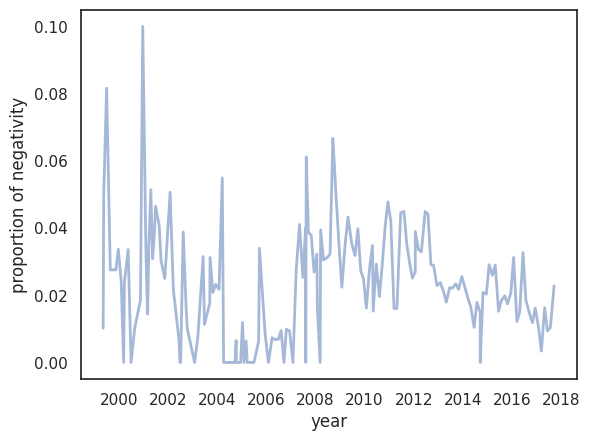

In [72]:
# Plot the proportion of negativity as a time series
fig, ax = plt.subplots()
ax.plot(x, negativity_proportion, 'b-', linewidth=2, label='Negativity', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of negativity')
plt.show()

In [73]:
# Export the proportion of negativity to csv file
NegProp = pd.DataFrame(negativity_proportion)
NegProp.to_csv("results/negativity.csv")

## Part 9: Calculating Uncertainty in FOMC Statements

In this section, I look to calculate a level of uncertainty in each document. Similar to the previous section, I use a dictionary-based method incorporating the sentimental list of words provided in the financial dictionary by Loughran and McDonald (2011). This allows me to come up with a measure of uncertainty within the statements. The literature looks at uncertainty as a main contributor to financial market volatility, which is channeled into risk premia. Using this measure, we may look at the influence of uncertainty on volatility.

In [80]:
# Read in pdf file of list of uncertain financial terms
pdfFileObj2 = open('/content/LM_Uncertainty.pdf','rb')
pdfReader2 = PyPDF2.PdfReader(pdfFileObj2)
len(pdfReader2.pages)

7

In [82]:
# Collect the uncertainty terms on each page into a list
uncertainty=[]
for pageNum in range(0, len(pdfReader2.pages)):
    pageObj2 = pdfReader2.pages[pageNum]
    uncertainty.append(CountVectorizer().build_tokenizer()(pageObj2.extract_text().lower()))
uncertainty

[['loughran',
  'mcdonald',
  'sentiment',
  'word',
  'lists',
  'uncertainty',
  'abeyance',
  'abeyances',
  'almost',
  'alteration',
  'alterations',
  'ambiguities',
  'ambiguity',
  'ambiguous',
  'anomalies',
  'anomalous',
  'anomalously',
  'anomaly',
  'anticipate',
  'anticipated',
  'anticipates',
  'anticipating',
  'anticipation',
  'anticipations',
  'apparent',
  'apparently',
  'appear',
  'appeared',
  'appearing',
  'appears',
  'approximate',
  'approximated',
  'approximately',
  'approximates',
  'approximating',
  'approximation',
  'approximations',
  'arbitrarily',
  'arbitrariness',
  'arbitrary',
  'assume',
  'assumed',
  'assumes',
  'assuming',
  'assumption',
  'assumptions',
  'believe',
  'believed',
  'believes',
  'believing'],
 ['cautious',
  'cautiously',
  'cautiousness',
  'clarification',
  'clarifications',
  'conceivable',
  'conceivably',
  'conditional',
  'conditionally',
  'confuses',
  'confusing',
  'confusingly',
  'confusion',
  'conti

In [83]:
# Delete the first six terms that are simply part of the list description
del uncertainty[0][0:6]

In [84]:
# Calculate the sum of uncertain terms within each statement
uncertain_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    uncertain_count = 0
    fomc = statements[i]
    for word in fomc:
        for unc in uncertainty:
            if((word in set(unc)) == True):
                uncertain_count += 1
    uncertain_sum[i] = uncertain_count

In [85]:
# Transform the uncertainty sum list into a numpy array and calculate percentage of uncertainty
uncertain_sum = np.asarray(uncertain_sum)
uncertainty_proportion = uncertain_sum/doc_length

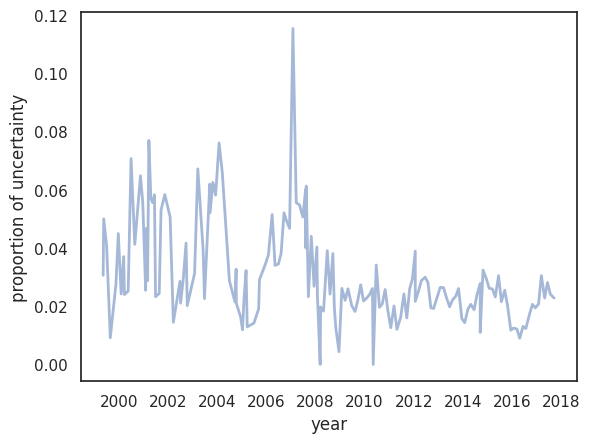

In [86]:
# Plot the proportion of uncertainty as a time series
fig, ax = plt.subplots()
ax.plot(x, uncertainty_proportion, 'b-', linewidth=2, label='Uncertainty', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of uncertainty')
plt.show()

In [87]:
# Export the uncertainty proportion to a csv file
UncertProp = pd.DataFrame(uncertainty_proportion)
UncertProp.to_csv("results/uncertainty.csv")

## Part 10: Regression Analysis

In [88]:
from pandas_datareader import data
import statsmodels.api as sm

In [89]:
# Want to look at influence of changes in topics
W_diff = W.diff() # w_diff = w(t) - w(t-1)
W_diff = np.asarray(W_diff)

In [90]:
# Set end dates
start_date = x[0]
end_date = x[-1]

### Alternative: Fetching VIX data from FRED

To use the FRED API, you'll need a free API key. You can register for one on the [FRED website](https://fred.stlouisfed.org/docs/api/api_key.html).

Once you have your API key, you can set it as an environment variable or pass it directly to `pandas_datareader`.

In [100]:
import pandas_datareader as pdr
import os

# Replace 'YOUR_FRED_API_KEY' with your actual FRED API key.
# You can also set it as an environment variable (e.g., FRED_API_KEY)
# and pandas_datareader will automatically pick it up.
FRED_API_KEY = 'YOUR_FRED_API_KEY'

# Set FRED API key as an environment variable
os.environ['FRED_API_KEY'] = FRED_API_KEY

# VIX (CBOE Volatility Index) series ID on FRED is 'VIXCLS'
# You can find other series IDs on the FRED website.
try:
    vix_fred = pdr.get_data_fred('VIXCLS', start=start_date, end=end_date)
    print("VIX data fetched successfully from FRED:")
    display(vix_fred.head())
    # Now, assign the 'VIXCLS' column to your 'y' variable
    y = vix_fred['VIXCLS']
    print("\nShape of fetched VIX data:", y.shape)

except Exception as e:
    print(f"Error fetching data from FRED: {e}")
    print("Please ensure your FRED API key is correct and uncommented, or explore manual download options.")

# Proceed with the rest of your regression analysis if data is successfully fetched
if 'y' in locals() and not y.empty:
    # Ensure y is aligned with X if necessary, or re-run previous steps
    # For now, let's just make sure it's a Series and has a datetime index
    if not isinstance(y.index, pd.DatetimeIndex):
        y.index = pd.to_datetime(y.index)

    # Re-align X with the new y if their indices might differ
    # This part depends on how X was created and if it needs resampling or alignment
    # For simplicity, assuming X_cons will be recreated based on this new y

    # Continue with regression (assuming X_cons is defined in a subsequent cell or re-defined here)
    # For this demonstration, we'll just show y's head.
    # Note: You will need to re-evaluate how X is constructed to match this new VIX data.


VIX data fetched successfully from FRED:


,VIXCLS
DATE,
1999-05-10,26.62
1999-05-11,25.62
1999-05-12,26.13
1999-05-13,25.02
1999-05-14,26.86



Shape of fetched VIX data: (4793,)


In [102]:
# Construct X matrix for regression

# W_diff is already a numpy array of shape (159, 3) representing changes in topic weights.
# x is a list of 159 datetime.date objects, corresponding to each row in W_diff.

# Create a DataFrame for W_diff with statement dates as index
W_diff_df = pd.DataFrame(W_diff, index=pd.to_datetime(x))
W_diff_df.columns = [f'Topic_{i+1}_diff' for i in range(W_diff.shape[1])]

# `y` is already defined from FRED as a Series of daily VIX values (vix_fred['VIXCLS'])

# Align the daily VIX data (`y`) with the statement dates.
# We will reindex the VIX series to the statement dates and forward-fill missing values
# (e.g., if a statement date falls on a weekend or holiday, take the previous available VIX value).
# This creates a 'y_reg' that corresponds to each statement date.
y_reg_aligned = y.reindex(W_diff_df.index, method='ffill')

# Combine W_diff_df and the aligned y_reg_aligned into a single DataFrame
regression_data = pd.concat([W_diff_df, y_reg_aligned.rename('VIX')], axis=1)

# Drop rows that contain NaNs. W_diff has NaN in its first row due to differencing,
# so this will effectively remove the first statement's data point, which is standard.
regression_data = regression_data.dropna()

# Extract the X and y for the regression model
X = regression_data.drop('VIX', axis=1).values # All columns except the VIX
y = regression_data['VIX'].values            # The VIX column is now the dependent variable 'y'

In [103]:
# Estimate OLS
X_cons = sm.add_constant(X) # add column of ones/intercept
model = sm.OLS(y[1:], X_cons[1:,:]) # drop row with NaNs due to first differencing
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.1128
Date:                Thu, 11 Dec 2025   Prob (F-statistic):              0.952
Time:                        13:05:16   Log-Likelihood:                -571.30
No. Observations:                 157   AIC:                             1151.
Df Residuals:                     153   BIC:                             1163.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.6423      0.746     27.680      0.0

### Finding:
In this extremely simple model, there is evidence that more central bank __communication related to financial markets__ contributes to __increased stock market volatility__.

### Issue:
Model is underspecified and could be better. Many factors contribute to stock market volatility.